In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

## Extract, Transform, Load

In [2]:
#torch.utils.data.Dataset is an abstract class, so we should implement __getitem__ and __len__

In [3]:
train_set = torchvision.datasets.FashionMNIST(
root = './data/FashionMNIST', #location on disk
train = True,
download = True,
transform = transforms.Compose([
    transforms.ToTensor()
])
)


In [4]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)

In [5]:
len(train_set)

60000

In [6]:
train_set.targets.bincount()

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [7]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [8]:
sample = next(iter(train_set))

In [9]:
len(sample) #img, and label

2

In [10]:
image, label = sample

In [11]:
image.shape

torch.Size([1, 28, 28])

label:9


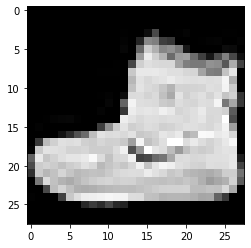

In [12]:
plt.imshow(image.squeeze(), cmap='gray')
print(f'label:{label}')

In [13]:
batch = next(iter(train_loader))

In [14]:
len(batch)

2

In [15]:
type(batch)

list

In [16]:
images, labels = batch

In [17]:
images.shape

torch.Size([100, 1, 28, 28])

In [18]:
labels.shape

torch.Size([100])

labels:tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5, 2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3,
        0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5, 0, 2, 0, 0, 4, 1, 3, 1,
        6, 3, 1, 4, 4, 6, 1, 9, 1, 3, 5, 7, 9, 7, 1, 7, 9, 9, 9, 3, 2, 9, 3, 6,
        4, 1, 1, 8])


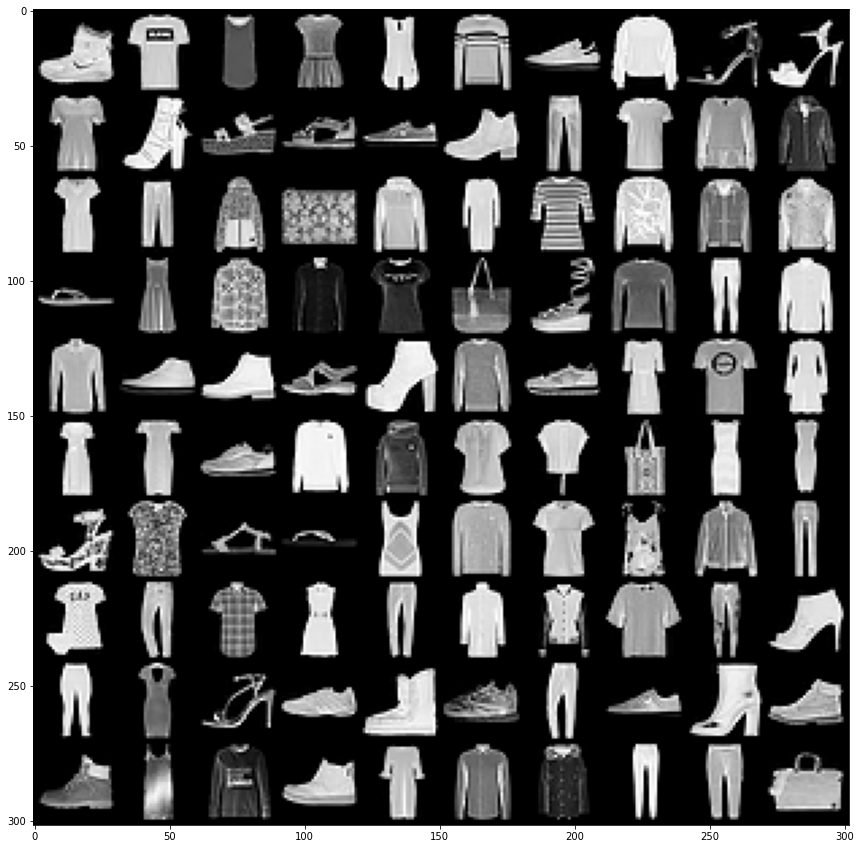

In [19]:
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print(f'labels:{labels}')

In [20]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5) #in_channels = 1 becoz it is grayscale
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
#         print(self.conv2.shape) #Formula = O= ((n-f+2p)/s)+1
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # (1) input layer
        t = t
        
        #(2) hidden conv layer
        t = self.conv1(t) #convolution operation
        t = F.relu(t) #operation
        t = F.max_pool2d(t, kernel_size=2, stride=2) #operation
        
        #(3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t) #becuase they don't have learnable parameters, so they come from Functional module
        t = F.max_pool2d(t, kernel_size=2, stride=2) #operations
        
        #(4) Linear
        t = t.reshape(-1, 12*4*4) # 12 is num of output channels, 4 X 4 is height and width
        t = self.fc1(t)
        t = F.relu(t)
        
        #(5) Linear 2
        t = self.fc2(t)
        t = F.relu(t)
        
        # Output Layer
        t = self.out(t)
#         t = F.softmax(t, dim = 1) # crossentropy loss function implicitly performs the softmax operation
        
        return t
        

In [21]:
network = Network()
torch.set_printoptions(linewidth=120)
# torch.set_grad_enabled(True) #if we dont want grad calc, set False
print(network)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [22]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
batch = next(iter(train_loader))
images, labels = batch

# Calculating Loss

In [191]:
preds = network(images)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=0.01)
loss = criterion(preds,labels)
loss.item()

2.1348187923431396

In [24]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [200]:
optimizer.zero_grad()
loss.backward() #calculate grads
optimizer.step() #update weights

In [201]:
loss = criterion(preds,labels)
loss.item()

2.2187376022338867

In [202]:
preds = network(images)
loss = criterion(preds,labels)
loss.item()

2.1179490089416504

In [203]:
get_num_correct(preds,labels)

22

# Training with epoch

In [25]:
network = Network()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=0.01)



for epoch in range(5):
    total_correct = 0
    total_loss = 0
    passes = 0

    for batch in train_loader:
        passes+=1
        images, labels = batch

        preds = network(images)
        loss = criterion(preds, labels)



        optimizer.zero_grad() #zero the gradients, otherwise grads+=loss.backward()
        loss.backward() #calculate gradients
        optimizer.step() #update weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(f'epoch:{epoch}, total_correct:{total_correct}, total_loss:{total_loss}, in {passes} passes')


epoch:0, total_correct:46778, total_loss:350.9929356276989, in 600 passes
epoch:1, total_correct:51388, total_loss:233.42346017062664, in 600 passes
epoch:2, total_correct:52181, total_loss:210.5362887531519, in 600 passes
epoch:3, total_correct:52584, total_loss:200.88093687593937, in 600 passes
epoch:4, total_correct:52740, total_loss:194.18046125769615, in 600 passes


In [26]:
total_correct/len(train_set)

0.879

# Get Prediction for all training labels

In [27]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

In [28]:
with torch.no_grad(): #you could also decorate the function @torch.no_grad()
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size = 10000)
    train_preds = get_all_preds(network, prediction_loader)

In [30]:
print(train_preds.requires_grad) # because we wrapped it into with torch.no_grad()

False


In [31]:
train_preds.shape

torch.Size([60000, 10])

In [32]:
preds_correct = get_num_correct(train_preds, train_set.targets)
print(f'Total_correct:{preds_correct}')
print(f'Accuracy:{preds_correct/len(train_set)}')

Total_correct:52864
Accuracy:0.8810666666666667


# Build a Confusion Matrix

In [34]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [36]:
train_preds.argmax(dim=1)

tensor([9, 0, 0,  ..., 3, 0, 5])

In [39]:
stacked = torch.stack([train_set.targets, train_preds.argmax(dim=1)], dim=1)#dim = 1 vertical stacking

In [41]:
stacked

tensor([[9, 9],
        [0, 0],
        [0, 0],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])

In [42]:
stacked.shape

torch.Size([60000, 2])

In [43]:
cmt = torch.zeros(10,10, dtype = torch.int32)

In [44]:
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [47]:
cmt = torch.zeros(10,10, dtype = torch.int32)
for p in stacked:
    tl, pl = p.tolist() #tl - true label; pl- predicted label
    cmt[tl,pl]+=1

In [48]:
cmt

tensor([[5724,   19,   68,   45,   13,    0,   96,    0,   33,    2],
        [  16, 5908,    4,   54,    5,    0,    6,    0,    7,    0],
        [ 182,    8, 4674,   45,  788,    2,  263,    0,   37,    1],
        [ 322,  132,   27, 5330,  129,    0,   51,    0,    7,    2],
        [  37,   48,  239,  257, 5114,    0,  263,    0,   42,    0],
        [   2,    0,    0,    0,    0, 5819,    0,  127,    8,   44],
        [1667,   22,  636,   99,  690,    0, 2820,    0,   66,    0],
        [   0,    0,    0,    0,    0,   53,    0, 5852,    5,   90],
        [  20,    3,   18,   18,   10,    9,   20,    5, 5888,    9],
        [   0,    0,    0,    0,    0,   24,    0,  237,    4, 5735]], dtype=torch.int32)

# Plotting a confusion matrix

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [50]:
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
cm

array([[5724,   19,   68,   45,   13,    0,   96,    0,   33,    2],
       [  16, 5908,    4,   54,    5,    0,    6,    0,    7,    0],
       [ 182,    8, 4674,   45,  788,    2,  263,    0,   37,    1],
       [ 322,  132,   27, 5330,  129,    0,   51,    0,    7,    2],
       [  37,   48,  239,  257, 5114,    0,  263,    0,   42,    0],
       [   2,    0,    0,    0,    0, 5819,    0,  127,    8,   44],
       [1667,   22,  636,   99,  690,    0, 2820,    0,   66,    0],
       [   0,    0,    0,    0,    0,   53,    0, 5852,    5,   90],
       [  20,    3,   18,   18,   10,    9,   20,    5, 5888,    9],
       [   0,    0,    0,    0,    0,   24,    0,  237,    4, 5735]])

In [56]:
names = ('T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')


In [57]:
df_cm = pd.DataFrame(cm, index = names,
                  columns = names)

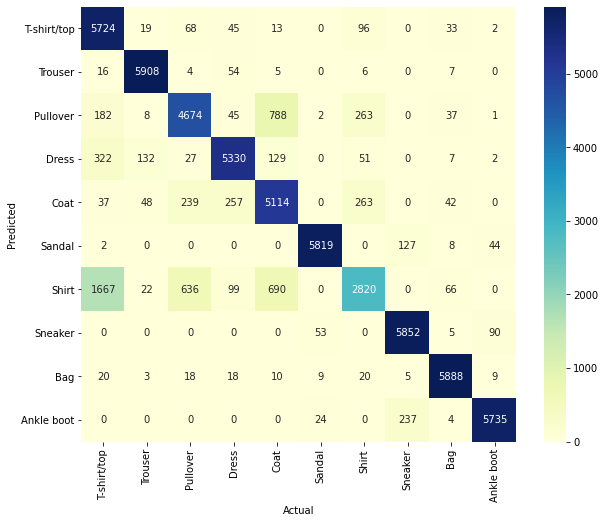

In [67]:
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True, square = True, fmt='g',cmap="YlGnBu");  #https://seaborn.pydata.org/generated/seaborn.heatmap.html
plt.xlabel('Actual');
plt.ylabel('Predicted');

In [68]:
sample = next(iter(train_set))
image, label = sample
image.shape

torch.Size([1, 28, 28])

In [72]:
#network expeects a batch, right now it is (channel, height,width), should be (batch,channel, height,width)
# forward methods in PyTorch NN module Conv classes expect a batch dimension
image.unsqueeze(dim=0).shape #dim=0, means add batch dimension as first dimension

torch.Size([1, 1, 28, 28])

In [81]:
pred = network(image.unsqueeze(0)) #image shape needs to be (batchXchannelsXHXW)

In [85]:
pred.argmax().item()

7

In [86]:
label

9

In [87]:
sample = next(iter(train_loader))

In [88]:
images, labels = sample

In [89]:
images.shape

torch.Size([10, 1, 28, 28])

In [90]:
labels

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])

In [91]:
pred = network(images)

In [92]:
pred

tensor([[-0.0455, -0.0741,  0.0338, -0.0338,  0.0644, -0.0454,  0.0574,  0.1322,  0.0815,  0.0030],
        [-0.0435, -0.0721,  0.0377, -0.0390,  0.0534, -0.0486,  0.0552,  0.1481,  0.0787, -0.0032],
        [-0.0412, -0.0738,  0.0333, -0.0430,  0.0620, -0.0537,  0.0523,  0.1408,  0.0840,  0.0005],
        [-0.0409, -0.0710,  0.0316, -0.0413,  0.0635, -0.0530,  0.0528,  0.1396,  0.0804,  0.0027],
        [-0.0461, -0.0647,  0.0365, -0.0379,  0.0640, -0.0521,  0.0516,  0.1412,  0.0771,  0.0023],
        [-0.0398, -0.0715,  0.0322, -0.0383,  0.0621, -0.0496,  0.0550,  0.1392,  0.0807,  0.0022],
        [-0.0466, -0.0792,  0.0346, -0.0366,  0.0570, -0.0470,  0.0519,  0.1376,  0.0833, -0.0056],
        [-0.0448, -0.0734,  0.0341, -0.0353,  0.0597, -0.0464,  0.0520,  0.1382,  0.0815,  0.0064],
        [-0.0410, -0.0744,  0.0347, -0.0355,  0.0660, -0.0543,  0.0527,  0.1376,  0.0840,  0.0019],
        [-0.0400, -0.0741,  0.0356, -0.0421,  0.0618, -0.0458,  0.0528,  0.1390,  0.0805, -0.0047]])

In [96]:
pred.argmax(dim=1)

tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [99]:
labels

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])

In [100]:
pred.argmax(dim=1).eq(labels).sum() #how many were correct preds?

tensor(1)

In [102]:
get_num_correct(pred, labels)

1

In [40]:
#Showing what callability means
class Test:
    def __init__(self, x, y):
        self.x, self.y = x,y
        
    def __call__(self, multiplier):
        return multiplier * self.x * self.y
    
test = Test(1,1)
test(4)

4

In [45]:
network.conv1.weight.shape #6 filters, 1 channel, 5 X 5 kernel size

torch.Size([6, 1, 5, 5])

In [46]:
network.conv1.weight

Parameter containing:
tensor([[[[ 0.1625, -0.0192,  0.0532,  0.1448, -0.1460],
          [ 0.1534, -0.1409, -0.1928,  0.1402,  0.0235],
          [-0.0824,  0.1967, -0.1986,  0.1665, -0.1104],
          [-0.0859, -0.1133, -0.1173, -0.1755,  0.1940],
          [ 0.1122,  0.1575,  0.0518, -0.0920, -0.0722]]],


        [[[ 0.1195, -0.1905,  0.1228,  0.1405,  0.1723],
          [ 0.0819,  0.1583,  0.0376,  0.1340, -0.1840],
          [-0.1929, -0.0169, -0.0408,  0.1051,  0.1907],
          [-0.0471,  0.0762, -0.0406,  0.1079,  0.0182],
          [-0.0067,  0.1157, -0.1015,  0.1310,  0.1201]]],


        [[[-0.0870,  0.0718,  0.0164,  0.0090, -0.0235],
          [-0.1438, -0.0349, -0.0162, -0.1262,  0.0628],
          [ 0.0064,  0.1292,  0.1946, -0.1953, -0.0861],
          [ 0.0432,  0.1491,  0.0006,  0.0047, -0.1313],
          [-0.1953, -0.1409, -0.1850,  0.1647, -0.0621]]],


        [[[-0.1596, -0.1706,  0.0034,  0.0409, -0.1184],
          [ 0.1125,  0.1646, -0.1856,  0.1358, -0.0203

In [48]:
network.conv2.weight.shape

torch.Size([12, 6, 5, 5])

In [49]:
network.fc1.weight.shape

torch.Size([120, 192])

In [50]:
network.fc2.weight.shape

torch.Size([60, 120])

In [51]:
network.out.weight.shape #output, input

torch.Size([10, 60])

In [52]:
for param in network.parameters():
    print(param.shape)

torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([12, 6, 5, 5])
torch.Size([12])
torch.Size([120, 192])
torch.Size([120])
torch.Size([60, 120])
torch.Size([60])
torch.Size([10, 60])
torch.Size([10])


In [54]:
for name,param in network.named_parameters():
    print(name,'\t',param.shape)

conv1.weight 	 torch.Size([6, 1, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([12, 6, 5, 5])
conv2.bias 	 torch.Size([12])
fc1.weight 	 torch.Size([120, 192])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([60, 120])
fc2.bias 	 torch.Size([60])
out.weight 	 torch.Size([10, 60])
out.bias 	 torch.Size([10])


In [62]:
lin = nn.Linear(in_features=3, out_features=4)
t = torch.rand(1,3)
lin(t) #<- because it is callable (__call__)

tensor([[ 0.1179,  0.1749,  0.3463, -0.5918]], grad_fn=<AddmmBackward>)